In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [2]:
csv_path = Path(r"..\datasets\housing\housing.csv")
if not csv_path.exists():
    raise FileNotFoundError("No se encontró 'housing.csv' en el directorio actual")
df = pd.read_csv(csv_path)


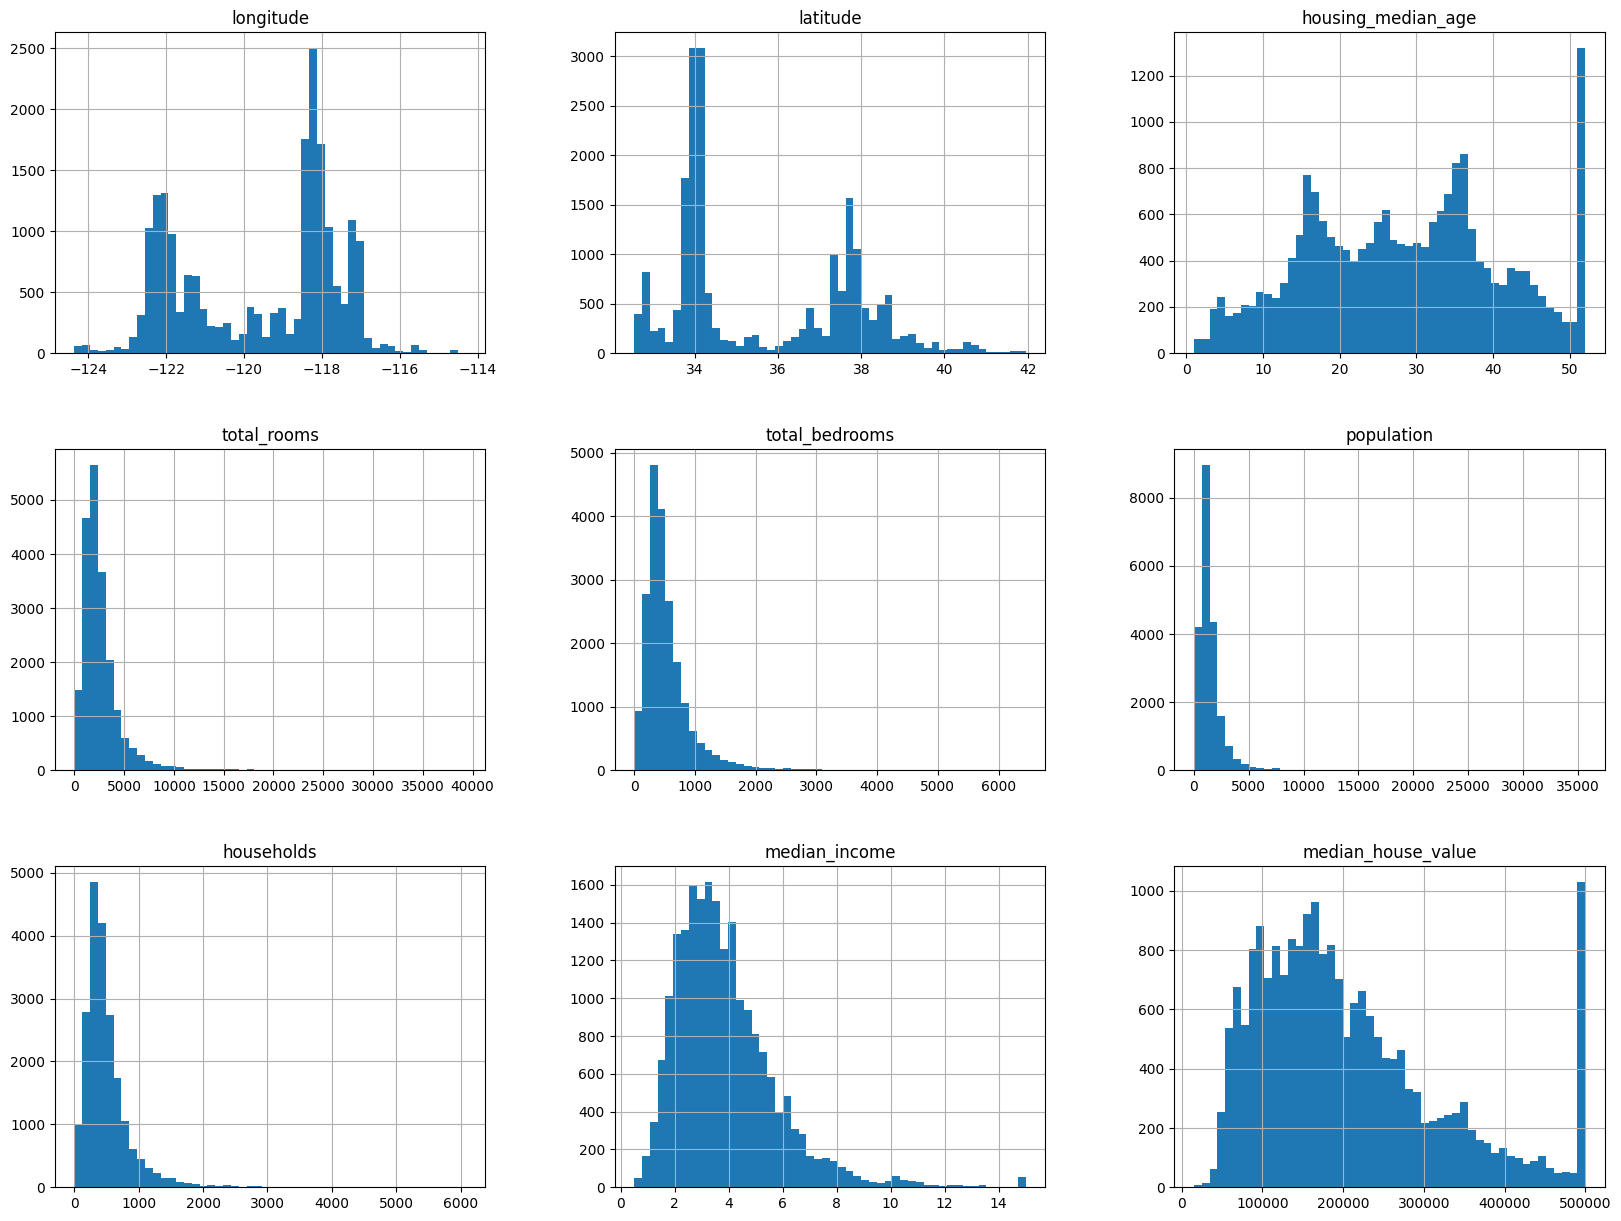

In [3]:
df.hist(bins=50, figsize=(20,15))
plt.show()

In [4]:
# creación del training set
def shufle_and_split_data(dataframe, test_ratio):
    shuffled_indices = np.random.permutation(len(dataframe))
    test_set_size = int(len(dataframe) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return dataframe.iloc[train_indices], dataframe.iloc[test_indices]

train_set, test_set = shufle_and_split_data(df, 0.2)
print(f"Rows in train set: {len(train_set)}\nRows in test set: {len(test_set)}")

Rows in train set: 16512
Rows in test set: 4128


In [5]:
# enlistar las filas del conjunto de entrenamiento
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

df_with_id = df.reset_index()  # crear una columna 'index' como ID
train_set, test_set = split_data_with_id_hash(df_with_id, 0.2, 'index')

df_with_id["id"]= df["longitude"] * 1000 + df["latitude"]
train_set, test_set = split_data_with_id_hash(df_with_id, 0.2, 'id')

In [6]:
#Parte del entrenamiento
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

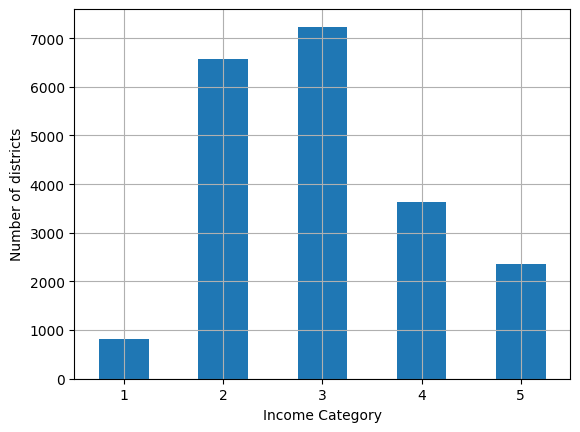

In [7]:
# Tomamos una parte de la data para la media sobre las categrías de ingresos
df["income_cat"] = pd.cut(df["median_income"],
                            bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                            labels=[1, 2, 3, 4, 5])

df["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of districts")
plt.show()

In [ ]:
#Divisiones estratificadas del modelo

from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Ejecutar el split y obtener directamente los conjuntos como DataFrames
for train_index, test_index in splitter.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

# Mostrar proporciones por categoría en el conjunto de prueba
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [9]:
# Por el momento no podemos usar más la columna de categorías de ingresos, así que la eliminamos de ambos conjuntos
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [10]:
# Usaremos una copia del conjunto de entrenamiento para exploración y análisis
housing = strat_train_set.copy()

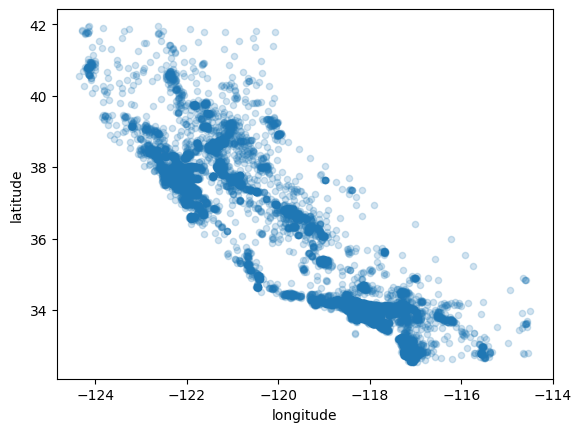

In [11]:
# Muestra geografica con enfoque de densidad
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2)
plt.show()

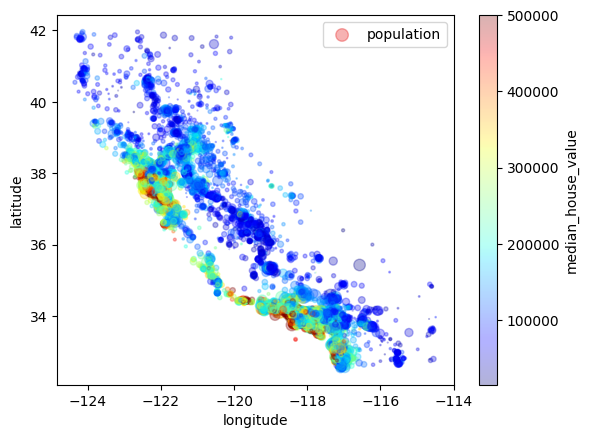

In [12]:
# Ahora con detalles en los precios, rojo es caro y azul es barato
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3,
             s=housing["population"]/100, label="population",
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show()

In [13]:
# Como nuestro muestreo es corto, podemos calcular la correlación de Pearson directamente
# Excluimos las columnas no numéricas (p. ej. 'ocean_proximity') antes de calcular la correlación
numeric_housing = housing.select_dtypes(include=[np.number])
corr_matrix = numeric_housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

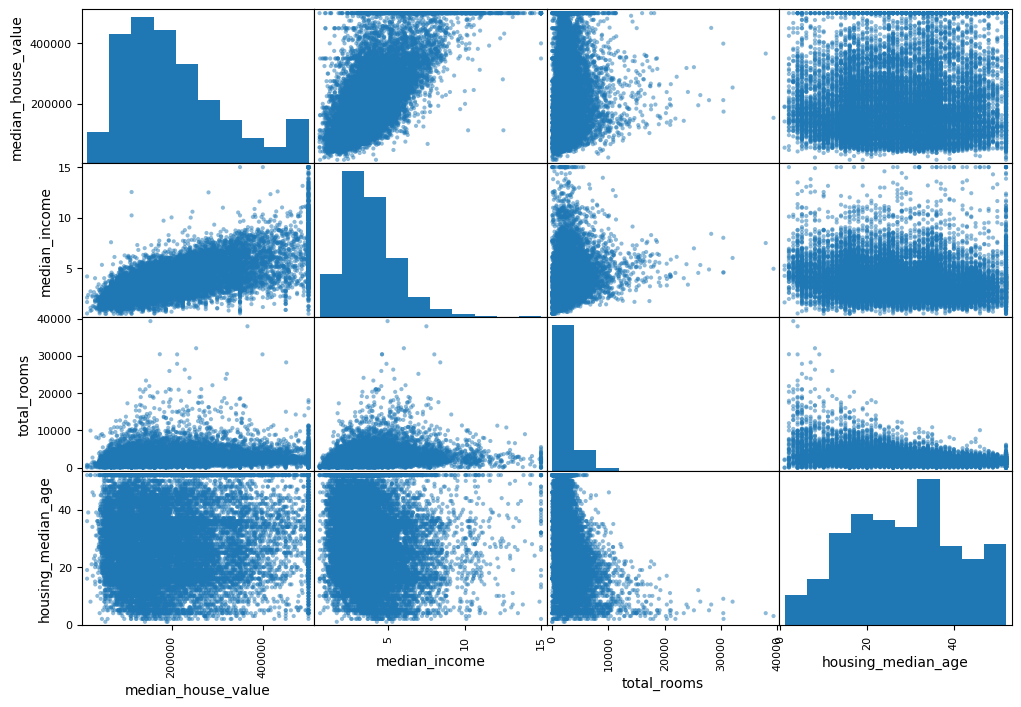

In [14]:
# Podemos ver la correlacion de otra forma a traves de un scatter matrix
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

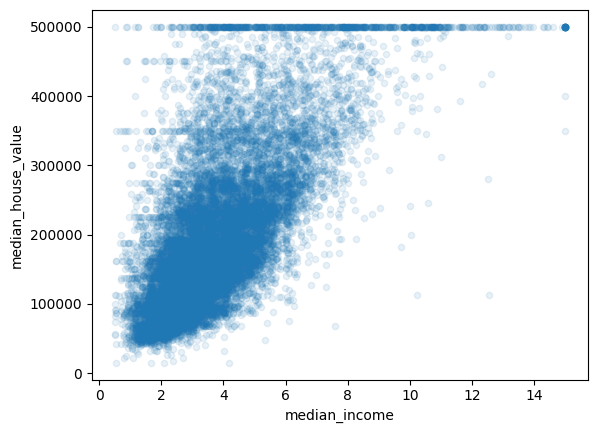

In [15]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.show()

In [16]:
# Algo interesante tambien es crear nuevas características a partir de las existentes
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]


In [17]:
# Podemos ver algunas correlaciones interesantes
numeric_housing = housing.select_dtypes(include=[np.number])
# usar solo las columnas numéricas para evitar errores con columnas de texto (p. ej. 'ocean_proximity')
corr_matrix = numeric_housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688380
rooms_per_household         0.143663
total_rooms                 0.137455
housing_median_age          0.102175
households                  0.071426
total_bedrooms              0.054635
population                 -0.020153
population_per_household   -0.038224
longitude                  -0.050859
latitude                   -0.139584
bedrooms_per_room          -0.256397
Name: median_house_value, dtype: float64

In [18]:
housing = strat_train_set.drop("median_house_value", axis=1)  # características
housing_labels = strat_train_set["median_house_value"].copy()    # etiquetas

In [19]:
# Estas son 3 opciones para imputar datos sin usar skelearnm la tercera es más destructiva que las demás

# housing.dropna(subset=["total_bedrooms"], inplace=True)  # eliminar filas con valores faltantes en total_bedrooms
# housing.drop("total_bedrooms", axis=1, inplace=True)  # eliminar la columna total_bedrooms

# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace=True)  # reemplazar

In [20]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
# Elimino la columna de texto porque SimpleImputer solo funciona con datos numéricos
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [21]:
print(imputer.statistics_)
print(housing_num.median().values)

[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]
[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]


In [22]:
# Con el imputer entrenado, podemos transformar el conjunto de datos para completar los valores faltantes

x = imputer.transform(housing_num)

In [23]:
# En nuestro caso, el resultado es una matriz NumPy, así que debemos convertirla de nuevo a un DataFrame    

housing_tr = pd.DataFrame(x, columns=housing_num.columns, index=housing_num.index)

In [24]:
# Demos un vistazo al atributo categórico 'ocean_proximity'
housing_cat = housing[["ocean_proximity"]]
print(housing_cat.head(10))

      ocean_proximity
13096        NEAR BAY
14973       <1H OCEAN
3785           INLAND
14689          INLAND
20507      NEAR OCEAN
1286           INLAND
18078       <1H OCEAN
4396         NEAR BAY
18031       <1H OCEAN
6753        <1H OCEAN


In [25]:
# Vamos a convertir estas categorías de texto en números usando OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
print(housing_cat_encoded[:10])

# lista de categorías
print(ordinal_encoder.categories_)

[[3.]
 [0.]
 [1.]
 [1.]
 [4.]
 [1.]
 [0.]
 [3.]
 [0.]
 [0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [26]:
# Para una representación one-hot, usamos OneHotEncoder, esto crea una columna binaria para cada categoría y evitar que el modelo interprete un orden entre las categorías
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder()
housing_cat_onehot = one_hot_encoder.fit_transform(housing_cat)
print(housing_cat_onehot.toarray())

[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [27]:
# Ahora veamos cómo manejar la columna categórica 'ocean_proximity', con un estimador personalizado y ColumnTransformer
df_test = pd.DataFrame({
    'ocean_proximity': ['NEAR BAY', '<1H OCEAN', 'INLAND']
})

one_hot_encoder.handle_unknown = "ignore"
one_hot_encoder.transform(df_test)

print(one_hot_encoder.feature_names_in_)
print(one_hot_encoder.get_feature_names_out())

# Crear un DataFrame con los resultados one-hot
df_output = pd.DataFrame(one_hot_encoder.transform(df_test).toarray(),
                         columns=one_hot_encoder.get_feature_names_out(),
                         index=df_test.index)

print("Dataframe: ", df_output)

['ocean_proximity']
['ocean_proximity_<1H OCEAN' 'ocean_proximity_INLAND'
 'ocean_proximity_ISLAND' 'ocean_proximity_NEAR BAY'
 'ocean_proximity_NEAR OCEAN']
Dataframe:     ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  ocean_proximity_ISLAND  \
0                        0.0                     0.0                     0.0   
1                        1.0                     0.0                     0.0   
2                        0.0                     1.0                     0.0   

   ocean_proximity_NEAR BAY  ocean_proximity_NEAR OCEAN  
0                       1.0                         0.0  
1                       0.0                         0.0  
2                       0.0                         0.0  


In [28]:
# Veremos como usar el minmaxscaler para escalar las características numéricas, esto nos permite transformar las características para que estén en un rango específico, generalmente entre 0 y 1.
from sklearn.preprocessing import MinMaxScaler

# Crear el MinMaxScaler con un rango personalizado, por ejemplo entre -1 y 1, esto nos permite ajustar el rango de los datos según nuestras necesidades.
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [29]:
# Otro camino es usar StandardScaler, que estandariza las características eliminando la media y escalándolas a la varianza unitária
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
housing_num_std_scaled = standard_scaler.fit_transform(housing_num)

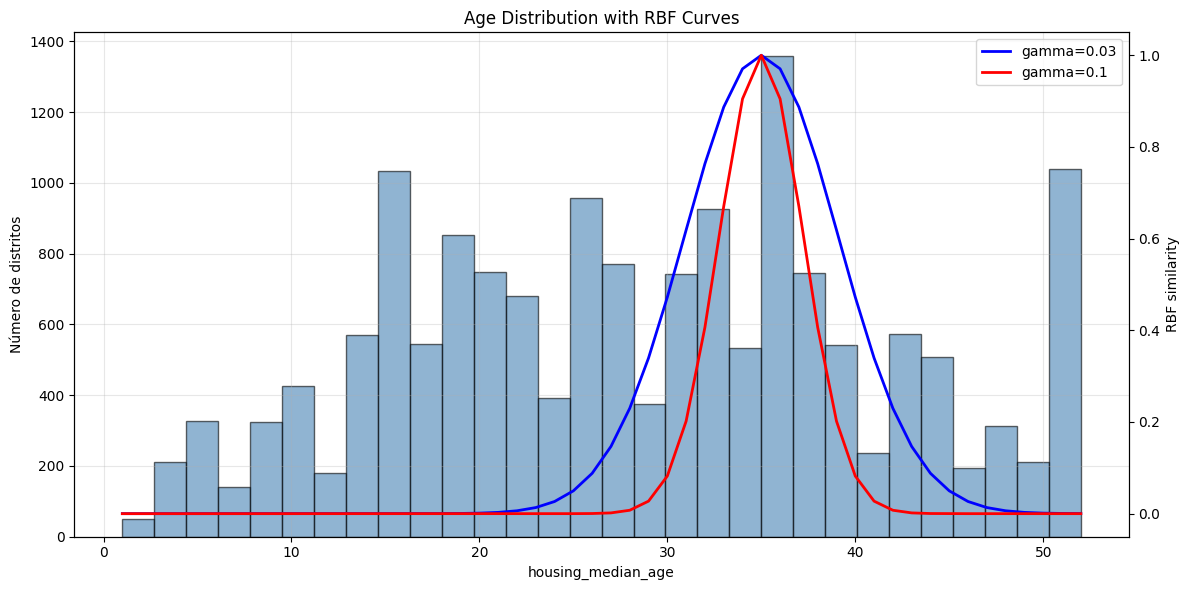

In [30]:
# Una forma de ver la función de base radial(RBF), que es comúnmente usada en máquinas de vectores de soporte y redes neuronales es a través de la fórmula matemática:
def rbf(x, c, s):
    return np.exp(-((x - c) ** 2) / (2 * s ** 2))

# Nosotros la podemos usar para transformar una característica numérica en una representación basada en RBFs.
from sklearn.metrics.pairwise import rbf_kernel

# Calcular la similitud RBF de la característica 'housing_median_age' con respecto a un centro específico (por ejemplo, 35) y diferentes valores de gamma, gamma controla la anchura de la campana RBF.
age_simil_35 = rbf_kernel(housing_num[["housing_median_age"]], [[35]], gamma=0.03)
age_35 = rbf_kernel(housing_num[["housing_median_age"]], [[35]], gamma=0.1)

# Ordenar los datos por edad para graficar líneas suaves
sorted_indices = np.argsort(housing_num["housing_median_age"].values.flatten())
sorted_age = housing_num["housing_median_age"].values[sorted_indices]
sorted_simil_35 = age_simil_35[sorted_indices]
sorted_age_35 = age_35[sorted_indices]

fig, ax = plt.subplots(figsize=(12, 6))

# Gráfico RBF con diferentes gammas superpuesto al histograma
ax.hist(housing_num["housing_median_age"], bins=30, color='steelblue', edgecolor='black', alpha=0.6, density=False)
ax2 = ax.twinx()
ax2.plot(sorted_age, sorted_simil_35, "b-", linewidth=2, label="gamma=0.03")
ax2.plot(sorted_age, sorted_age_35, "r-", linewidth=2, label="gamma=0.1")
ax.set_xlabel("housing_median_age")
ax.set_ylabel("Número de distritos")
ax2.set_ylabel("RBF similarity")
ax.set_title("Age Distribution with RBF Curves")
ax2.legend(loc="upper right")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
from sklearn.linear_model import LinearRegression

# Escala los valores objetivo (etiquetas) a media 0 y desviación estándar 1
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

# Crea y entrena el modelo de regresión lineal
model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)

# Obtiene 5 muestras de nuevos datos
some_new_data = housing[["median_income"]].iloc[:5]

# Realiza predicciones con los datos escalados
scaled_preds = model.predict(some_new_data)

# Convierte las predicciones escaladas de vuelta a la escala original
final_preds = target_scaler.inverse_transform(scaled_preds)

print(final_preds)

[[131997.15275877]
 [299359.35844434]
 [146023.37185694]
 [138840.33653057]
 [192016.61557639]]


In [32]:
# Otra forma de hacer esto es usando TransformedTargetRegressor de sklearn, que maneja automáticamente la transformación de las etiquetas durante el entrenamiento y la predicción.
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
final_preds = model.predict(some_new_data)
print(final_preds)

[131997.15275877 299359.35844434 146023.37185694 138840.33653057
 192016.61557639]


In [33]:
from sklearn.preprocessing import FunctionTransformer

# Una transformación logarítmica puede ser útil para características con una distribución sesgada
def log_transform(x):
    return np.log(x + 1)  # Agregar 1 para evitar log(0)

# usar FunctionTransformer para aplicar la transformación logarítmica
log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)
log_pop = log_transformer.fit_transform(housing[["population"]])
print(log_pop[:5])

       population
13096    7.363280
14973    6.502790
3785     6.333280
14689    7.520776
20507    7.556428


In [34]:
# Podemos crear transformaciones personalizadas más complejas usando FunctionTransformer
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35]], gamma=0.1))
age_simil_35 = rbf_transformer.fit_transform(housing[["housing_median_age"]])
print('Similaridad con edad 35:', age_simil_35[:5])

sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.fit_transform(housing[["latitude", "longitude"]])
print('Similaridad entre distritos de San Francisco:', sf_simil[:5])

ratio_transformer = FunctionTransformer(lambda x: x[:, 0] / x[:, 1]) # total_bedrooms / total_rooms
print('Similaridad de ratio:', ratio_transformer.transform(np.array([[1.,2], [3.,4.]])))

Similaridad con edad 35: [[2.81118530e-13]
 [8.20849986e-02]
 [6.70320046e-01]
 [8.48904403e-15]
 [9.04837418e-01]]
Similaridad entre distritos de San Francisco: [[0.999927  ]
 [0.05258419]
 [0.94864161]
 [0.01192662]
 [0.03275557]]
Similaridad de ratio: [0.5  0.75]


In [35]:
# Crearemos nuestro clon de un scaler standard, esto es útil para entender cómo funcionan los transformadores en sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array

class MyStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean

    def fit(self, X, y=None): # y es opcional, se incluye para compatibilidad con pipelines
        X = check_array(X) # Validar la entrada
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)
        self.n_features_in_ = X.shape[1] # Número de características, necesario para la validación
        return self # devolver el objeto entrenado

    def transform(self, X):
        check_is_fitted(self) # Verificar si el transformador ha sido entrenado
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1], ("El número de características no coincide con el del entrenamiento.")
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [36]:
# También podemos realizar nuestro cluster personalizado usando KMeans
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin): # Transforma características basadas en la similitud a centros de clústeres
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None): # y es opcional, se incluye para compatibilidad con pipelines
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X): # Calcular la similitud RBF entre los puntos de datos y los centros de clústeres
        check_is_fitted(self)
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma) # Devolver como columna
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster_{i} Similarity" for i in range(self.n_clusters)]

In [37]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=0.1, random_state=42) # Crear el transformador de similitud de clústeres
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels) # Calcular similitudes con ponderación de etiquetas

In [38]:
print(similarities[:3].round(2)) # Mostrar las primeras 3 filas de similitudes redondeadas a 2 decimales

[[0.02 1.   0.19 0.01 0.5  0.41 0.81 0.94 0.05 0.94]
 [0.96 0.06 0.8  0.72 0.   0.44 0.07 0.02 1.   0.11]
 [0.02 0.96 0.16 0.   0.63 0.44 0.93 0.95 0.04 0.88]]


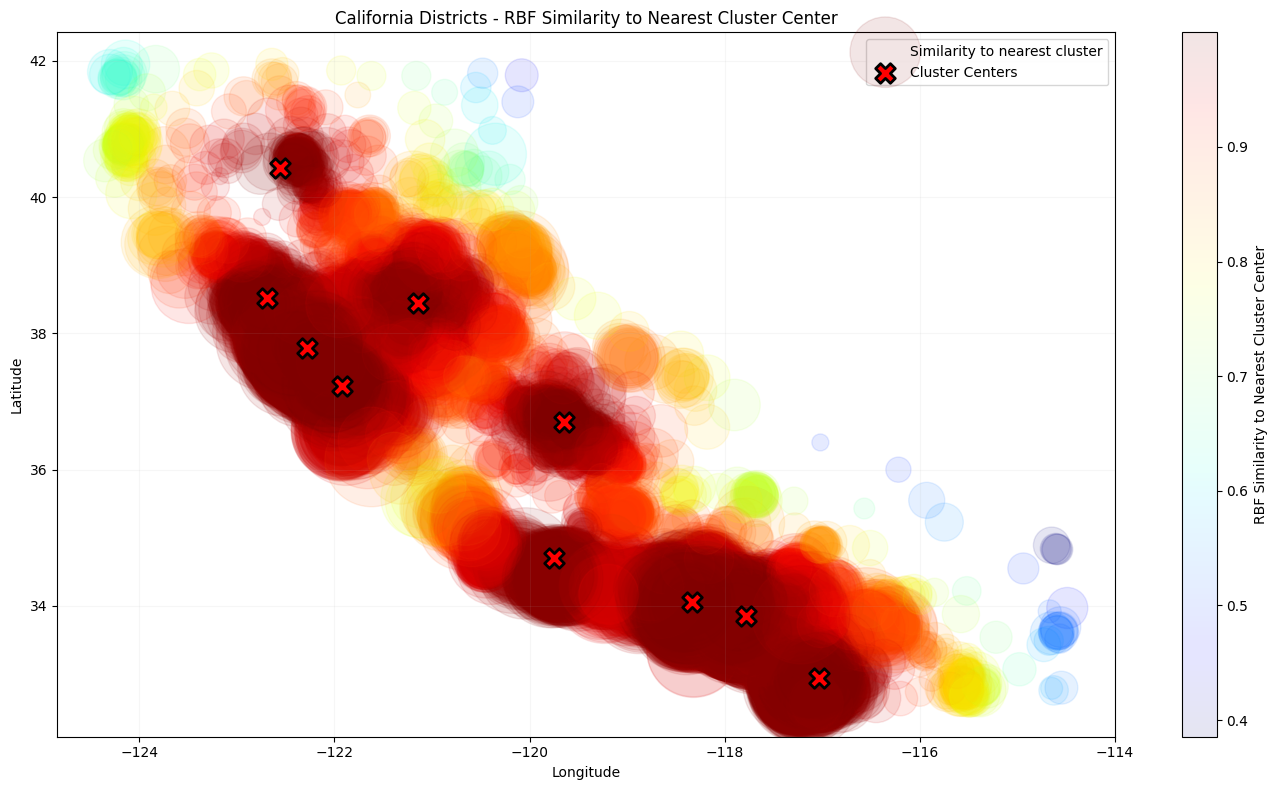

In [39]:
# Visualizar el mapa de California con colores según la similitud al centro de clúster más cercano
# Obtener la similitud máxima (al clúster más cercano) para cada distrito
max_cluster_similarity = similarities.max(axis=1)

# Crear el gráfico
plt.figure(figsize=(14, 8))
plt.scatter(housing["longitude"], housing["latitude"], 
            c=max_cluster_similarity, 
            cmap='jet', 
            alpha=0.1,
            s=housing_labels/100,
            label='Similarity to nearest cluster')
plt.colorbar(label='RBF Similarity to Nearest Cluster Center')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('California Districts - RBF Similarity to Nearest Cluster Center')
plt.legend()
plt.grid(True, alpha=0.1)

# Marcar los centros de los clústeres
cluster_centers = cluster_simil.kmeans_.cluster_centers_
plt.scatter(cluster_centers[:, 1], cluster_centers[:, 0], 
            c='red', 
            marker='X', 
            s=200, 
            edgecolors='black',
            linewidths=2,
            label='Cluster Centers',
            zorder=5)

plt.legend()
plt.tight_layout()
plt.show()

In [40]:
from sklearn.pipeline import Pipeline, make_pipeline # Para crear pipelines de procesamiento de datos 

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy="median")),
    ('standardize', StandardScaler()),
])  # Crear un pipeline para procesamiento numérico

n_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
) # Crear un pipeline para procesamiento numérico usando make_pipeline

In [41]:
housing_num_prepares = num_pipeline.fit_transform(housing_num) # Procesar los datos numéricos usando el pipeline
print(housing_num_prepares[:2].round(2))

[[-1.42  1.01  1.86  0.31  1.37  0.14  1.39 -0.94]
 [ 0.6  -0.7   0.91 -0.31 -0.44 -0.69 -0.37  1.17]]


In [42]:
df_housing_num_prepares = pd.DataFrame(housing_num_prepares,
                                       columns=num_pipeline.get_feature_names_out(),
                                        index=housing_num.index)
# Mostrar las primeras 2 filas del DataFrame procesado
print(df_housing_num_prepares.head(2).round(2))

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096      -1.42      1.01                1.86         0.31            1.37   
14973       0.60     -0.70                0.91        -0.31           -0.44   

       population  households  median_income  
13096        0.14        1.39          -0.94  
14973       -0.69       -0.37           1.17  


In [43]:
from sklearn.compose import ColumnTransformer

# Definir las columnas numéricas y categóricas
num_attributes = ["longitude", "latitude", "housing_median_age",
                  "total_rooms", "total_bedrooms", "population",
                  "households", "median_income"]
cat_attributes = ["ocean_proximity"]

# Crear pipelines para procesamiento numérico y categórico
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

# Combinar ambos pipelines en un ColumnTransformer
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attributes),
    ("cat", cat_pipeline, cat_attributes),
])

In [44]:
from sklearn.compose import make_column_selector, make_column_transformer

# Crear un ColumnTransformer usando selectores de columnas
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

# Aplicar el preprocesamiento completo al conjunto de datos
housing_prepared = preprocessing.fit_transform(housing)
print(housing_prepared[:2])

[[-1.42303652  1.0136059   1.86111875  0.31191221  1.36816703  0.13746004
   1.39481249 -0.93649149  0.          0.          0.          1.
   0.        ]
 [ 0.59639445 -0.702103    0.90762971 -0.30861991 -0.43592476 -0.69377062
  -0.37348471  1.17194198  1.          0.          0.          0.
   0.        ]]


In [45]:
# Crear una función para calcular la razón entre dos columnas
def column_ratio(X):
    ratio = X[:, 0] / X[:, 1]  # total_bedrooms / total_rooms
    return ratio.reshape(-1, 1)  # total_bedrooms / total_rooms

# ¡Es importante devolver un array 2D para sklearn, ya que espera una matriz de características!

# Definir una función para nombrar la característica de salida
def ratio_name(function_transformer, feature_names_in):
    return ["ratio"] # feature names out

# Crear un pipeline para la transformación basada en razones
def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )

# Crear el pipeline logarítmico, que aplica una transformación logarítmica seguida de estandarización
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log1p, feature_names_out="one-to-one"),
    StandardScaler()
)

# Crear el transformador de similitud de clústeres, usando los mismos parámetros anteriores
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=0.1, random_state=42)
default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

# Crear el ColumnTransformer completo con las nuevas transformaciones, incluyendo las basadas en razones, logarítmicas y de clústeres
preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("population_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms","total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
],    remainder=default_num_pipeline) # Procesar las demás columnas numéricas con el pipeline por defecto




In [46]:
housing_prepared = preprocessing.fit_transform(housing)

# Ver la forma del conjunto de datos preprocesado
print(housing_prepared.shape)

# Ver los nombres de las características generadas por el preprocesamiento
print(preprocessing.get_feature_names_out())

(16512, 24)
['bedrooms__ratio' 'rooms_per_house__ratio' 'population_per_house__ratio'
 'log__total_bedrooms' 'log__total_rooms' 'log__population'
 'log__households' 'log__median_income' 'geo__Cluster_0 Similarity'
 'geo__Cluster_1 Similarity' 'geo__Cluster_2 Similarity'
 'geo__Cluster_3 Similarity' 'geo__Cluster_4 Similarity'
 'geo__Cluster_5 Similarity' 'geo__Cluster_6 Similarity'
 'geo__Cluster_7 Similarity' 'geo__Cluster_8 Similarity'
 'geo__Cluster_9 Similarity' 'cat__ocean_proximity_<1H OCEAN'
 'cat__ocean_proximity_INLAND' 'cat__ocean_proximity_ISLAND'
 'cat__ocean_proximity_NEAR BAY' 'cat__ocean_proximity_NEAR OCEAN'
 'remainder__housing_median_age']


In [47]:
from sklearn.linear_model import LinearRegression

# Crear y entrenar un modelo de regresión lineal usando el pipeline completo, con los pasos anteriores se torna más sencillo
lin_reg =make_pipeline(
    preprocessing,
    LinearRegression()
)
# Entrenamos el modelo con el conjunto de datos completo
lin_reg.fit(housing, housing_labels)

,steps,"[('columntransformer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [48]:
housing_predictions = lin_reg.predict(housing)
# Mostrar las primeras 5 predicciones redondeadas a las centenas
print(housing_predictions[:5].round(-2))
print(list(housing_labels.iloc[:5]))

[260000. 365200. 133700. 105800. 318000.]
[458300.0, 483800.0, 101700.0, 96100.0, 361800.0]


In [49]:
from sklearn.metrics import root_mean_squared_error

# Calcular el RMSE del conjunto de entrenamiento, que mide la diferencia promedio entre las predicciones del modelo y los valores reales
mse = root_mean_squared_error(housing_labels, housing_predictions) # Calcular el RMSE
print(f"RMSE del conjunto de entrenamiento: {mse}")

RMSE del conjunto de entrenamiento: 66198.2349113623


In [50]:
from sklearn.tree import DecisionTreeRegressor # Importar el regresor de árbol de decisión

# Crear y entrenar un modelo de árbol de decisión usando el pipeline completo, este modelo puede capturar relaciones no lineales en los datos, por lo que a menudo tiene un mejor rendimiento que la regresión lineal.
tree_reg = make_pipeline(
    preprocessing,
    DecisionTreeRegressor(random_state=42)
)
tree_reg.fit(housing, housing_labels)
housing_predictions = tree_reg.predict(housing)
mse = root_mean_squared_error(housing_labels, housing_predictions)
print(f"RMSE del conjunto de entrenamiento: {mse}")

RMSE del conjunto de entrenamiento: 0.0


In [51]:
from sklearn.model_selection import cross_val_score # Para evaluar modelos usando validación cruzada, que ayuda a estimar el rendimiento del modelo en datos no vistos

# Evaluar el modelo de árbol de decisión usando validación cruzada, esto nos da una mejor idea del rendimiento del modelo en datos no vistos
scores = -cross_val_score(tree_reg, housing, housing_labels, scoring="neg_mean_squared_error", cv=10)

print("Scores de validación cruzada del árbol de decisión:", scores)
pd.Series(scores).describe()

Scores de validación cruzada del árbol de decisión: [4.31370746e+09 4.26041694e+09 4.46865662e+09 4.34543763e+09
 4.47821712e+09 4.46607717e+09 4.61594542e+09 4.71090806e+09
 4.38305397e+09 4.55430884e+09]


count    1.000000e+01
mean     4.459673e+09
std      1.401946e+08
min      4.260417e+09
25%      4.354842e+09
50%      4.467367e+09
75%      4.535286e+09
max      4.710908e+09
dtype: float64

In [52]:
from sklearn.ensemble import RandomForestRegressor

# Crear y entrenar un modelo de bosque aleatorio usando el pipeline completo, este modelo combina múltiples árboles de decisión para mejorar la precisión y reducir el sobreajuste
forest_reg = make_pipeline(
    preprocessing,
    RandomForestRegressor(random_state=42)
)

# Evaluar el modelo de bosque aleatorio usando validación cruzada, esto nos da una mejor idea del rendimiento del modelo en datos no vistos
forest_mse = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_mean_squared_error", cv=10)

pd.Series(forest_mse).describe()

count    1.000000e+01
mean     2.208262e+09
std      9.601686e+07
min      2.079597e+09
25%      2.157726e+09
50%      2.208769e+09
75%      2.240065e+09
max      2.417503e+09
dtype: float64

In [53]:
from sklearn.model_selection import GridSearchCV

# Crear el pipeline completo con el modelo de bosque aleatorio
full_pipeline = make_pipeline(
    preprocessing,
    RandomForestRegressor(random_state=42)
)

# Definir la cuadrícula de hiperparámetros para la búsqueda en cuadrícula, el lo asocia a traves del nombre del paso en el pipeline, osea columntransformer__X_n_clusters y el estimador final randomforestregressor__
param_grid = [
    {'columntransformer__geo__n_clusters': [5, 8, 10],
     'randomforestregressor__max_features': [4, 6, 8]},
    {'columntransformer__geo__n_clusters': [10, 15],
     'randomforestregressor__max_features': [6, 8, 10]},
]
# Se usa columntransformer__geo__n_clusters para referirse al número de clústeres en la transformación de similitud geográfica y randomforestregressor__max_features para referirse a la cantidad máxima de características a considerar en cada división del árbol en el modelo de bosque aleatorio.

# Realizar la búsqueda en cuadrícula con validación cruzada para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring="neg_root_mean_squared_error")
grid_search.fit(housing, housing_labels)

# Mostrar los mejores parámetros encontrados por la búsqueda en cuadrícula, en este caso, el número óptimo de clústeres y la cantidad máxima de características a considerar en cada división del árbol
print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'columntransformer__geo__n_clusters': 15, 'randomforestregressor__max_features': 6}


In [54]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_columntransformer__geo__n_clusters,param_randomforestregressor__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,13.540441,0.118114,0.283504,0.004587,15,6,"{'columntransformer__geo__n_clusters': 15, 'ra...",-43026.917180,-43476.057810,-44383.503633,-43628.826208,564.260778,1
13,17.782585,0.340892,0.285424,0.019214,15,8,"{'columntransformer__geo__n_clusters': 15, 'ra...",-43598.435545,-44102.904069,-44795.865759,-44165.735125,490.863583,2
6,9.197017,0.107846,0.282265,0.029782,10,4,"{'columntransformer__geo__n_clusters': 10, 'ra...",-43732.073708,-44138.589050,-44880.391715,-44250.351491,475.413289,3
9,12.895518,0.134993,0.268267,0.012633,10,6,"{'columntransformer__geo__n_clusters': 10, 'ra...",-43796.969025,-44464.804330,-45023.437899,-44428.403751,501.364955,4
7,13.007917,0.023195,0.274618,0.002289,10,6,"{'columntransformer__geo__n_clusters': 10, 'ra...",-43796.969025,-44464.804330,-45023.437899,-44428.403751,501.364955,4


In [55]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
# Definir la distribución de hiperparámetros para la búsqueda aleatoria, esto permite explorar un espacio más amplio de hiperparámetros de manera más eficiente que la búsqueda en cuadrícula

# Crear el pipeline completo con el modelo de bosque aleatorio
param_distribs = {"columntransformer__geo__n_clusters": randint(low=3, high=50),
                    "randomforestregressor__max_features": randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=param_distribs,
                                n_iter=10, cv=3, scoring="neg_mean_squared_error", random_state=42)

rnd_search.fit(housing, housing_labels)

print("Mejores parámetros (búsqueda aleatoria):", rnd_search.best_params_)

Mejores parámetros (búsqueda aleatoria): {'columntransformer__geo__n_clusters': 45, 'randomforestregressor__max_features': 9}


In [56]:
# Evaluar el mejor modelo encontrado por la búsqueda aleatoria usando validación cruzada
final_model = rnd_search.best_estimator_
feature_importances = final_model.named_steps["randomforestregressor"].feature_importances_
feature_importances.round(2)

# Ver la importancia de las características ordenadas de mayor a menor
sorted(zip(feature_importances, final_model["columntransformer"].get_feature_names_out()), reverse=True)




[(np.float64(0.19591242234441966), 'log__median_income'),
 (np.float64(0.07357583274583211), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.05987341115379615), 'bedrooms__ratio'),
 (np.float64(0.055963778063771744), 'rooms_per_house__ratio'),
 (np.float64(0.0468220145240083), 'population_per_house__ratio'),
 (np.float64(0.0452773944280695), 'geo__Cluster_30 Similarity'),
 (np.float64(0.024690602086453593), 'geo__Cluster_25 Similarity'),
 (np.float64(0.02366421272688763), 'geo__Cluster_9 Similarity'),
 (np.float64(0.022514775267256076), 'geo__Cluster_36 Similarity'),
 (np.float64(0.019278968924802513), 'geo__Cluster_37 Similarity'),
 (np.float64(0.018236174819210506), 'geo__Cluster_18 Similarity'),
 (np.float64(0.017608167981258867), 'geo__Cluster_34 Similarity'),
 (np.float64(0.015193587932236014), 'geo__Cluster_3 Similarity'),
 (np.float64(0.01444491641357634), 'geo__Cluster_0 Similarity'),
 (np.float64(0.014394934240290931), 'geo__Cluster_1 Similarity'),
 (np.float64(0.01370123722716

In [66]:
x_test = strat_test_set.drop("median_house_value", axis=1)  # características
y_test = strat_test_set["median_house_value"].copy()    # etiquetas

# Realizar predicciones en el conjunto de prueba usando el modelo final
final_predictions = final_model.predict(x_test)
final_mse = root_mean_squared_error(y_test, final_predictions)

print(f"RMSE del conjunto de prueba: {final_mse}")

RMSE del conjunto de prueba: 41601.823553148475


In [67]:
from scipy import stats
# Calcular el intervalo de confianza del 95% para el RMSE en el conjunto de prueba

confidence = 0.95

# Calcular el intervalo de confianza del 95% para el RMSE en el conjunto de prueba
square_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(square_errors) - 1,
                         loc=square_errors.mean(), scale=stats.sem(square_errors)))



array([39444.89467491, 43652.304979  ])

In [ ]:
import dill
#dill tiene mayores ventajas para el uso de aprendizaje, sin embaego jolib se usa para despliegues con más frecuencia y es el estandar en la industria

# Guardar
print("💾 Guardando modelo...")
with open("final_model.pkl", "wb") as f:
    dill.dump(final_model, f)
print("✓ Modelo guardado exitosamente")

# Verificar tamaño
import os
size_mb = os.path.getsize("final_model.pkl") / (1024 * 1024)
print(f"📦 Tamaño: {size_mb:.2f} MB")

# Cargar y probar
with open("final_model.pkl", "rb") as f:
    loaded_model = dill.load(f)

# Probar predicciones
new_data = x_test.iloc[:7]
predictions = loaded_model.predict(new_data)
print("🎯 Predicciones:", predictions)

💾 Guardando modelo...
✓ Modelo guardado exitosamente
📦 Tamaño: 138.13 MB
🎯 Predicciones: [411821.21 210642.   361884.28 331892.   269662.04 164720.   110626.  ]
